In [62]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt 
import textwrap

In [74]:
def customer_identifier(df): 
    '''
        It handles strings in the "Customer" column of the Products DataFrame.
        "Customer" values are strings with '-' character splitting customer names from countries and/or 
        another specifications such as competitor product/brand/company. 
        This method splits the string, maintaining at the Customer column only the actual customer name.
        The remaining info is reallocated to the new columns "Specifics" and "Competitor".
        It only applies to product DataFrame in this specific context!

        Arguments:
            df: DataFrame (product DataFrame)

        Returns:
            df_result: DataFrame (resulting DataFrame after string handling)
    '''

    df_result = df_prod
    df_result["Competitor"] = 0
    df_result["Specifics"] = df_result["Customer"]
    df_result["Specifics"] = df_result["Specifics"].str.replace(r'^.+ - ','')
    df_result["Customer"] = df_result["Customer"].str.replace(r' - .+$','')
    df_result.loc[(df_result["Specifics"].str.find("Concorrente")!=-1),"Competitor"] = 1
    df_result.loc[(df_result["Specifics"].str.find("Concorrente")!=-1),"Specifics"].str.replace("Concorrente",'')
    
    return df_result


def verify_inconsistences(df_coletas):
    '''
        It verifies some inconsistences in the DataFrame, such as the following situations:

        1. Uncompatible 'Availabe'-'Unavailable' values
        2. 'RandomPrecosNegativos' indicating positive final price while 
            'FinalPrice' value is actually negative
        3. 'RandomPrecosMissing' indicating missing final price while 'FinalPrice'
            value is not missing, or 'RandomPrecosMissing' indicating no missing value
            while 'FinalPrice' value is actually missing

        Arguments:
            df: DataFrame ('coletas' DataFrame)

        Returns:
            None
    '''

    # Situation 1
    assert df_coletas[(df_coletas["Available"]==df_coletas["Unavailable"])].empty,\
    "Inconsistencies with 'Available 'Unavailable' values!"
    
    # Situation 2
    assert df_coletas[(df_coletas["RandomPrecosNegativos"]==1)&(df_coletas["FinalPrice"]<0)].empty,\
    "Inconsistencies with negative final price values!"

    # Situation 3
    assert df_coletas.loc[
    ((df_coletas["RandomPrecosMissing"] == 0)&(df_coletas["FinalPrice"] != 0))|
    ((df_coletas["RandomPrecosMissing"] == 1)&(df_coletas["FinalPrice"] == 0)),"FinalPrice"
    ].empty, "Inconsistencies with values ​​missing from final prices!"
    
    return None


def fix_unconsistences(df_coletas, key_error):
    '''
        It fixes some inconsistences in the DataFrame, indicated by the 'key_error' string.

        1. 'missing':  If the Final Price is missing, we get Suggested Price instead
        2. 'negative': If the Final Price is negative, we get the mean of same EAN 
            positive Final Prices instead

        Arguments:
            df_coleta: DataFrame ('coletas' DataFrame)
            key_error: str (string indicating which type of inconsistence we're dealing with)

        Returns:
            df_coleta: DataFrame ('coletas' DataFrame with modifications)
    '''

    # Situation 1
    if (key_error == 'missing'):
        df_coletas.loc[((df_coletas["RandomPrecosMissing"] == 1)&(df_coletas["FinalPrice"] == 0)),"FinalPrice"
                        ] = df_coletas.loc[
                                        ((df_coletas["RandomPrecosMissing"] == 1)&(df_coletas["FinalPrice"]==0)),"SuggestedPrice"
                                        ]
        
    # Situation 2
    elif(key_error == 'negative'):
        mean_prices = pd.DataFrame(df_coletas.loc[(df_coletas["FinalPrice"] > 0),
                                ["FinalPrice","MasterKey_RetailerProduct"]].groupby("MasterKey_RetailerProduct").mean())


        for item in df_coletas.loc[(df_coletas["FinalPrice"] < 0),["FinalPrice","MasterKey_RetailerProduct"]].index.values:
            df_coletas.loc[item,"FinalPrice"] = mean_prices.loc[str(df_coletas.loc[item,"MasterKey_RetailerProduct"])]["FinalPrice"]

    return df_coletas

In [82]:
# Folder path
path =  "../data/"

# Which values are considered NaN
na_vls = ['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
               '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 
                'null', '...']

nrows = 100000

# Load datasets
df_prod = pd.read_csv(path+"ProdutosVarejos.csv", na_values = na_vls, nrows = nrows)
df_coletas = pd.read_csv(path+"Coletas.csv", na_values = na_vls, nrows = nrows)

# Handling missing values
df_coletas.dropna(inplace=True, how = 'all')
df_coletas.fillna(value = 0, inplace=True)
df_prod.dropna(inplace=True, how = 'all')
df_prod.fillna(value = '', inplace=True)

# Register DataFrames Shapes
clt_cols, clt_rows = df_coletas.shape
prd_cols, prod_rows = df_prod.shape

# Types for each DataFrame column
prod_types = {'Customer': 'str',
                'Department': 'str',
                'Category': 'str',
                'Brand': 'str',
                'EAN': 'str',
                'Product': 'str',
                'Retailer': 'str',
                'MasterKey_RetailerProduct': 'str'}

coletas_types = {'DateIns': 'str', 
                    'Screenshot': 'str', 
                    'Available': 'int64', 
                    'Unavailable': 'int64', 
                    'SuggestedPrice' : 'float64',
                    'FinalPrice': 'float64', 
                    'MasterKey_RetailerProduct': 'str', 
                    'RandomPrecosNegativos': 'int64',
                    'RandomPrecosMissing': 'int64', 
                    'RandomPrecosDiscrepantes': 'int64',
                    'RandomPrecosDiscrepantesFator': 'float64'}

# Casting DataFrames columns according to the types above
df_prod = df_prod.astype(prod_types)
df_coletas= df_coletas.astype(coletas_types)

# Adjusting strings in "Customer" column
df_prod = customer_identifier(df_prod)

# Transforming 'DateIns' column in a Pandas datetype time series
df_coletas["DateIns"] = pd.to_datetime(df_coletas["DateIns"].values)

# Formatting "Department","Category", "Product" columns strings to begin (each word) with upper case 
for cols in df_prod[["Department","Category", "Product"]]:
    df_prod[cols] = df_prod[cols].str.capitalize()

# Formatting "Brand" column value strings to begin with upper case  
df_prod.loc[(df_prod["Brand"] != df_prod["Customer"]),"Brand"].str.title()

# Inconsistences fixing and verification
df_coletas = fix_unconsistences(df_coletas, 'missing')
df_coletas = fix_unconsistences(df_coletas, 'negative')
verify_inconsistences(df_coletas)

C:\Users\luiza\AppData\Local\Temp\ipykernel_11696\94200046.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df_result["Specifics"] = df_result["Specifics"].str.replace(r'^.+ - ','')
C:\Users\luiza\AppData\Local\Temp\ipykernel_11696\94200046.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df_result["Customer"] = df_result["Customer"].str.replace(r' - .+$','')


C:\Users\luiza\AppData\Local\Temp\ipykernel_11696\2232794186.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()[["SuggestedPrice","FinalPrice"]]


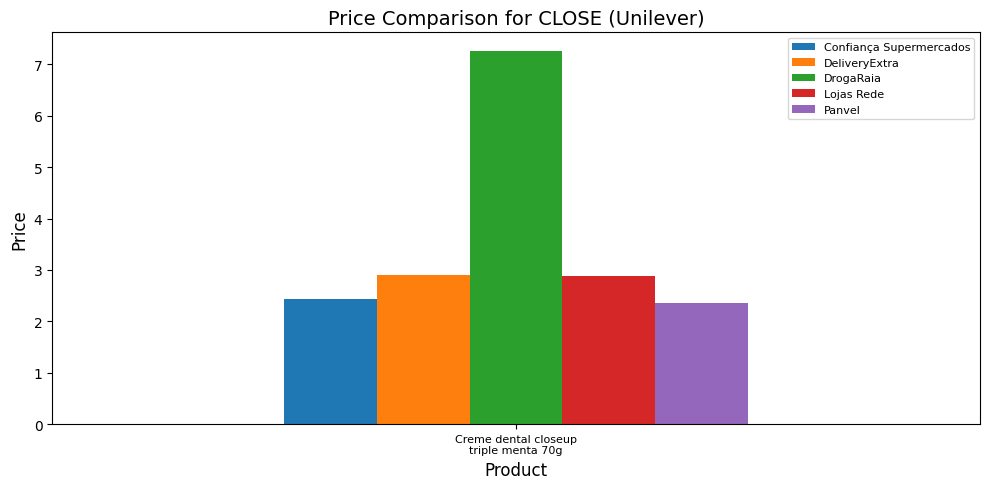

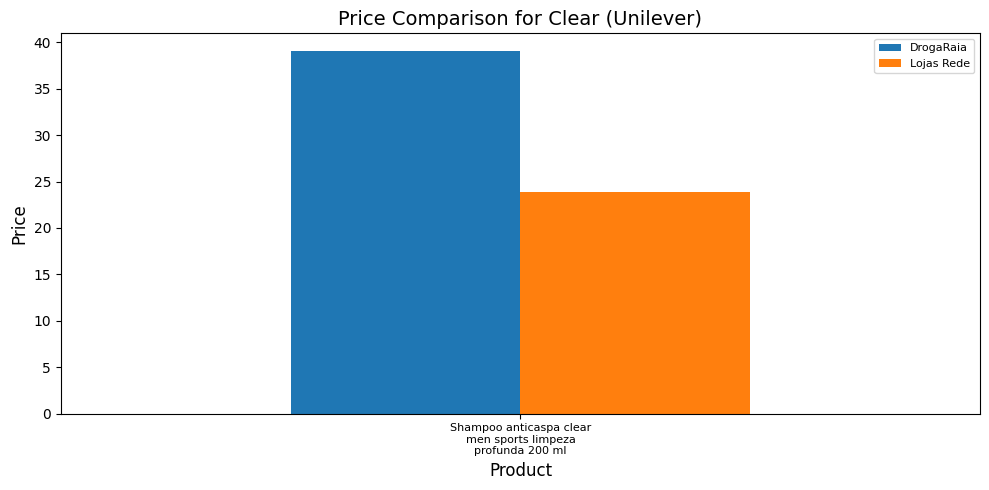

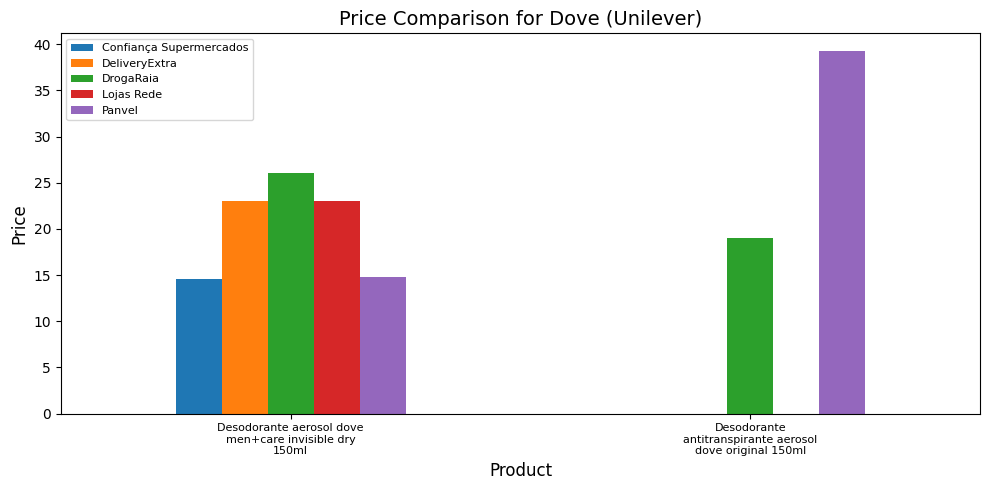

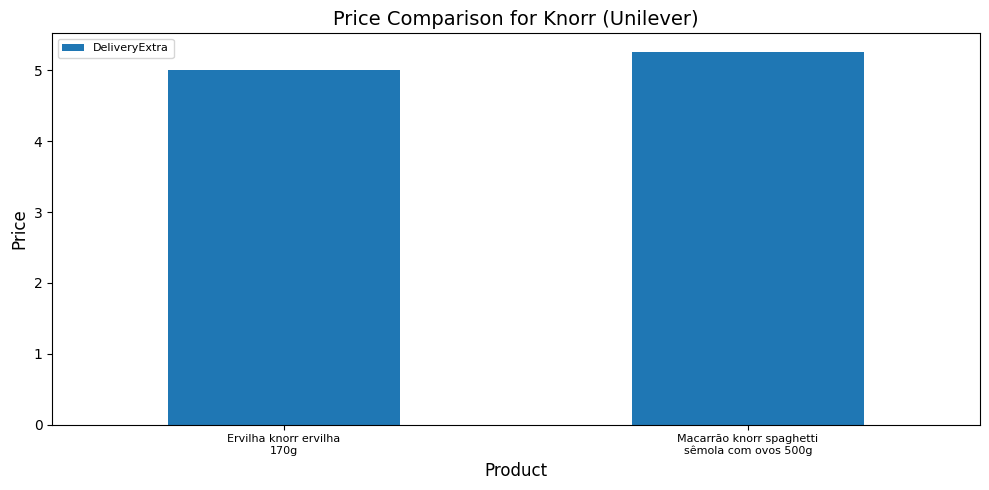

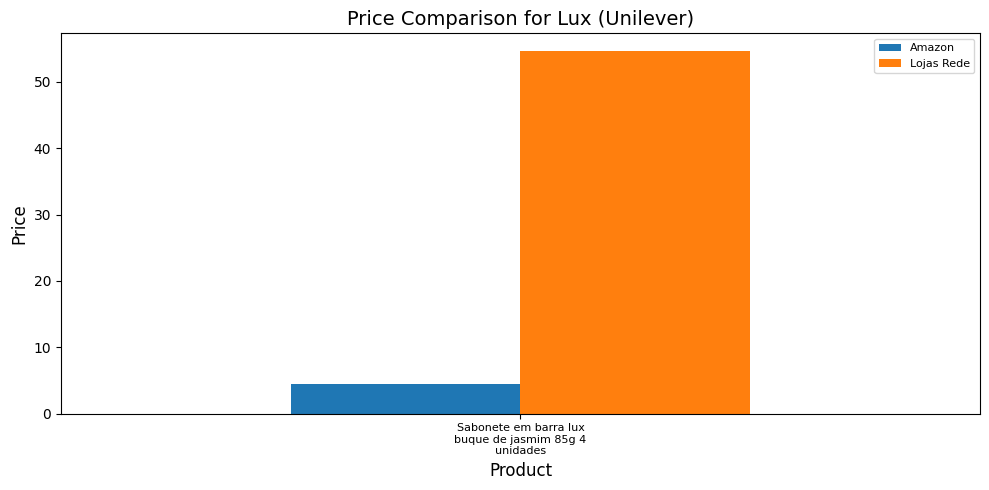

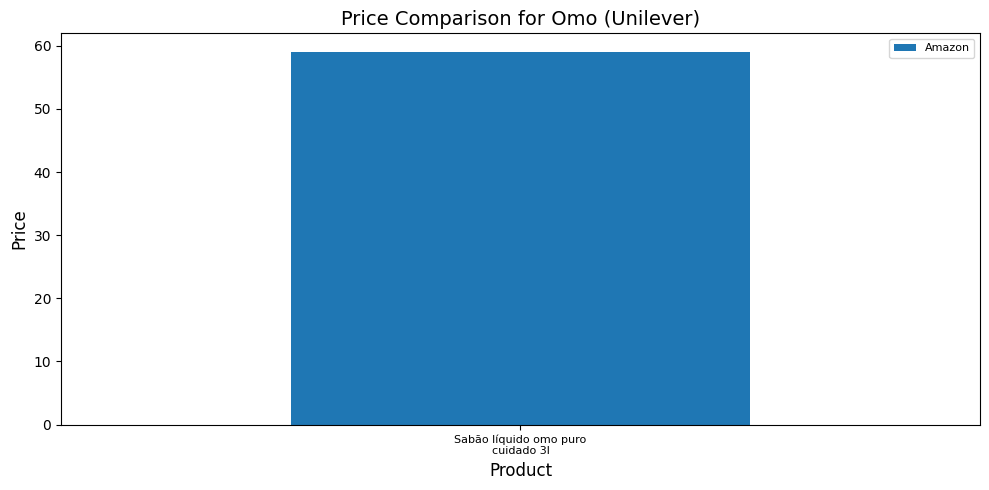

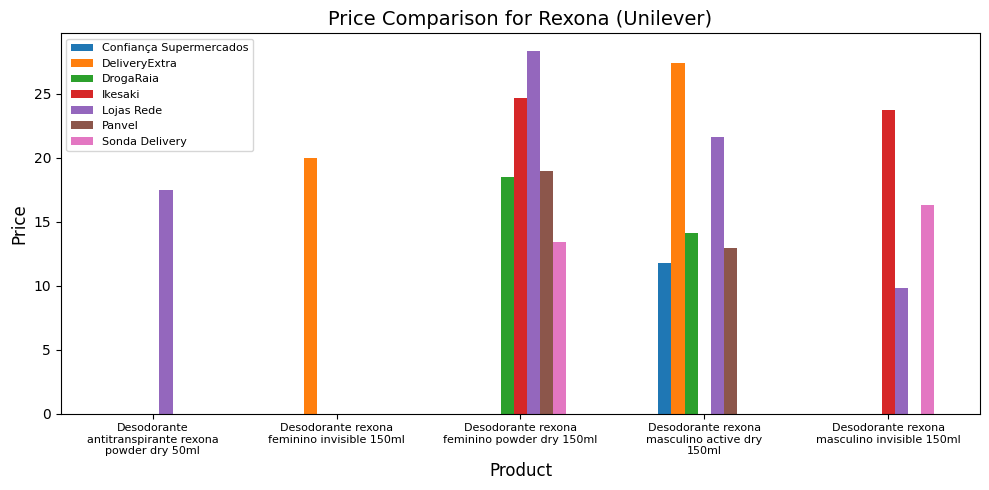

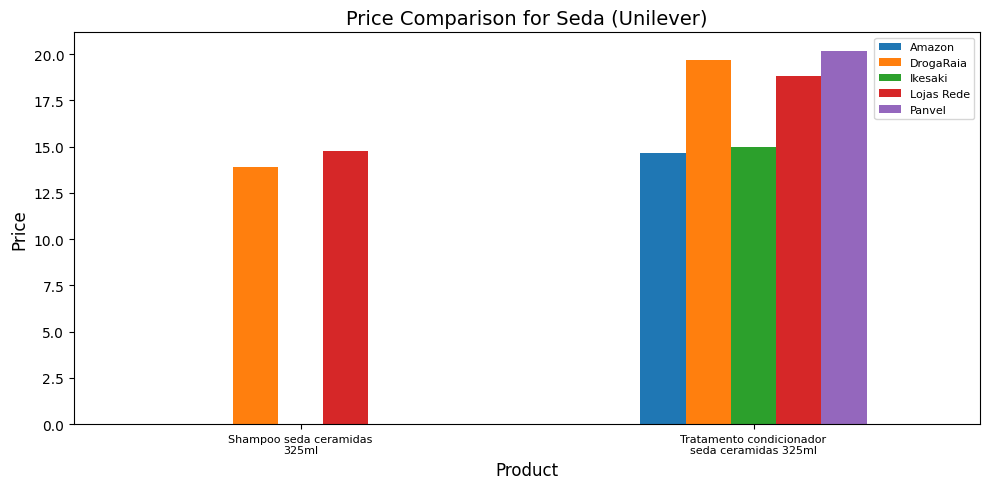

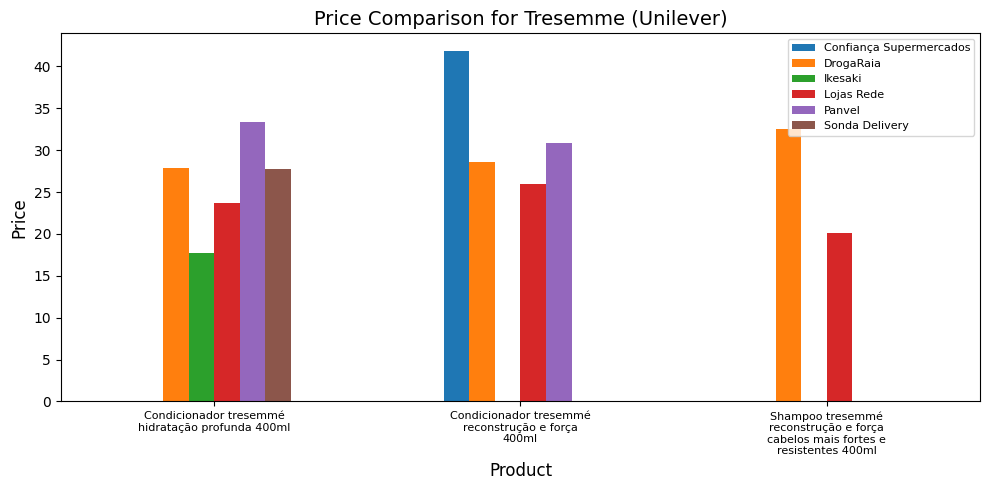

In [83]:
# Customer Price Analysis
selected_customer = 'Unilever'

df_join1 = df_prod.merge(right = df_coletas, how='inner',\
                    on = 'MasterKey_RetailerProduct').groupby(\
                        ["Customer","Specifics", "Competitor","Brand", "EAN", "Product", "Retailer"]\
                            ).mean()[["SuggestedPrice","FinalPrice"]]
df_join1["FinalPrice"] = np.round(df_join1["FinalPrice"].values,decimals = 2)
df_join1.reset_index(inplace = True)
df_join1

df_selected_customer = df_join1[df_join1["Customer"] == selected_customer]
for brand in pd.unique(df_selected_customer["Brand"]):
    df_selected_brand = df_selected_customer[df_selected_customer["Brand"] == brand]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_selected_brand.groupby(['EAN', 'Retailer','Product'])['FinalPrice'].mean().reset_index()
    
    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='Product', columns='Retailer', values='FinalPrice')

    # Create a bar chart for each EAN
    ax = pivot_data.plot(kind='bar', figsize=(10, 5))
    ax.set_xlabel('Product', fontsize=12)                                   # Xlabel font and size
    ax.set_ylabel('Price', fontsize=12)                                     # Ylabel font and size

    ax.set_title(f'Price Comparison for {brand} ({selected_customer})', fontsize=14)

    ax.legend(title='Retailer', loc='upper left', bbox_to_anchor=(1, 1))    # Legend position and title
    ax.legend(fontsize=8)                                                   # Legend font size

    # Break xlabels into multiple lines using textwrap
    wrapped_xlabels = [textwrap.fill(label, width=25) for label in pivot_data.index]
    ax.set_xticklabels(wrapped_xlabels, rotation=0, ha='center', fontsize=8)            # Xlabel rotation and position    

    plt.tight_layout()
    plt.show()
    
 

In [ ]:
df_coletas.groupby(['EAN','MasterKey_RetailerProduct','DateIns']).count()[["SuggestedPrice","FinalPrice"]]

In [96]:
# Customer Price Analysis
selected_customer = 'Unilever'

df_join1 = df_prod.merge(right = df_coletas, how='inner',\
                        on = 'MasterKey_RetailerProduct').groupby(\
                                                                ['EAN','MasterKey_RetailerProduct','DateIns']).mean()[\
                                                                ['SuggestedPrice','FinalPrice]']]


df_join1["FinalPrice"] = np.round(df_join1["FinalPrice"].values,decimals = 2)
df_join1.reset_index(inplace = True)
df_join1

df_selected_customer = df_join1[df_join1["Customer"] == selected_customer]
for brand in pd.unique(df_selected_customer["Brand"]):
    df_selected_brand = df_selected_customer[df_selected_customer["Brand"] == brand]
    
    # Group by EAN and Retailer, calculate mean price
    ean_retailer_prices = df_selected_brand.groupby(['EAN', 'Retailer'])['FinalPrice'].mean().reset_index()
    
    # Pivot the data for plotting
    pivot_data = ean_retailer_prices.pivot(index='Product', columns='Retailer', values='FinalPrice')

    # Create a bar chart for each EAN
    ax = pivot_data.plot(kind='bar', figsize=(10, 5))
    ax.set_xlabel('Product', fontsize=12)                                   # Xlabel font and size
    ax.set_ylabel('Price', fontsize=12)                                     # Ylabel font and size

    ax.set_title(f'Price Comparison for {brand} ({selected_customer})', fontsize=14)

    ax.legend(title='Retailer', loc='upper left', bbox_to_anchor=(1, 1))    # Legend position and title
    ax.legend(fontsize=8)                                                   # Legend font size

    # Break xlabels into multiple lines using textwrap
    wrapped_xlabels = [textwrap.fill(label, width=25) for label in pivot_data.index]
    ax.set_xticklabels(wrapped_xlabels, rotation=0, ha='center', fontsize=8)            # Xlabel rotation and position    

    plt.tight_layout()
    plt.show()

C:\Users\luiza\AppData\Local\Temp\ipykernel_11696\1622263095.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ['EAN','DateIns','MasterKey_RetailerProduct']).mean()[\


SuggestedPrice  \
EAN           DateIns    MasterKey_RetailerProduct                                            
4005808174478 2023-05-01 BRBeiersdorf400580817447889238-03300-31DrogaRaia             52.31   
                         BRBeiersdorf400580817447889238-03300-31Lojas Rede            52.31   
              2023-05-02 BRBeiersdorf400580817447889238-03300-31DrogaRaia             52.31   
                         BRBeiersdorf400580817447889238-03300-31Lojas Rede            52.31   
              2023-05-03 BRBeiersdorf400580817447889238-03300-31DrogaRaia             52.31   
...                                                                                     ...   
8715200813061 2023-06-28 BRBeiersdorf871520081306181306-03401-13Panvel                30.61   
              2023-06-29 BRBeiersdorf871520081306181306-03401-13EpocaCos...           35.90   
                         BRBeiersdorf871520081306181306-03401-13Panvel                30.61   
              2023-06-30 BRBeiersdorf871520081306181306-03401-13EpocaCos...           35.90   
                         BRBeiersdorf871520081306181306-03401-13Panvel                30.61   

                                                                             FinalPrice  
EAN           DateIns    MasterKey_RetailerProduct                                       
4005808174478 2023-05-01 BRBeiersdorf400580817447889238-03300-31DrogaRaia         46.10  
                         BRBeiersdorf400580817447889238-03300-31Lojas Rede        58.90  
              2023-05-02 BRBeiersdorf400580817447889238-03300-31DrogaRaia         45.04  
                         BRBeiersdorf400580817447889238-03300-31Lojas Rede        58.90  
              2023-05-03 BRBeiersdorf400580817447889238-03300-31DrogaRaia         45.04  
...                                                                                 ...  
8715200813061 2023-06-28 BRBeiersdorf871520081306181306-03401-13Panvel            46.99  
              2023-06-29 BRBeiersdorf871520081306181306-03401-13EpocaCos...       35.90  
                         BRBeiersdorf871520081306181306-03401-13Panvel            46.99  
              2023-06-30 BRBeiersdorf871520081306181306-03401-13EpocaCos...       35.90  
                         BRBeiersdorf871520081306181306-03401-13Panvel            46.99  

[18396 rows x 2 columns]

In [ ]:
# Client Analysis 
customer = "Unilever"	
brand = "Tresemme"
retailer = None
EAN = None
department = None
category = None

groups = ["EAN","DateIns"]
function = np.mean

df_join2 = df_prod.merge(right = df_coletas, how='inner',\
                    on = 'MasterKey_RetailerProduct')

result = df_join2[df_join2['Customer']==customer].groupby(groups)["FinalPrice"].apply(function, axis=0)
result
#grouping(df_join2[df_join2['Customer']==customer], groups = groups, function = np.mean)
#mean_over_key(df_join2, 'Customer', customer, groups = groups)

EAN            DateIns   
7506306241183  2023-05-14     21.99
               2023-05-15     21.99
               2023-05-16     21.99
               2023-05-17    151.57
               2023-05-18     18.99
                              ...  
78924338       2023-05-23     10.99
               2023-05-24      0.00
               2023-05-25     10.99
               2023-05-26     10.99
               2023-05-27     67.15
Name: FinalPrice, Length: 643, dtype: float64

In [ ]:
t_span = pd.to_datetime(pd.unique(df_join2["DateIns"]),format='%Y%m%d')